In [ ]:
import sys
sys.path.append('..')

In [2]:
import explain_utils
import explainer

In [3]:
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv
from torch_geometric.utils import negative_sampling, train_test_split_edges, remove_self_loops, add_self_loops

### Load data

In [4]:
# dataset = 'Cora'
dataset = 'Citeseer'
dataset = Planetoid('data', dataset, transform=T.NormalizeFeatures())
data = dataset[0]

data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)

### Build Model

In [5]:
class Model(nn.Module):
    def __init__(self, feature_num: int, hidden_size: int = 8, heads: int = 8, dropout: float = 0.5):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv(feature_num, hidden_size, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_size * heads, hidden_size, heads=heads, concat=True, dropout=dropout)
        #self.conv3 = GATConv(hidden_size * heads, hidden_size, heads=heads, concat=True, dropout=dropout)

    def forward(self, x, pos_edge_index, neg_edge_index):
        attentions = []

        x, (attn_edge_index, attention) = self.conv1(x, pos_edge_index, return_attention_weights=True)
        attentions.append((attn_edge_index.detach(), attention.detach()))
        x = nn.ReLU()(x)

        x, (attn_edge_index, attention) = self.conv2(x, pos_edge_index, return_attention_weights=True)
        attentions.append((attn_edge_index.detach(), attention.detach()))
        x = nn.ReLU()(x)
        
#         x, (attn_edge_index, attention) = self.conv3(x, pos_edge_index, return_attention_weights=True)
#         attentions.append((attn_edge_index.detach(), attention.detach()))
#         x = nn.ReLU()(x)

        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        x_j = torch.index_select(x, 0, edge_index[0])
        x_i = torch.index_select(x, 0, edge_index[1])
        logits = torch.einsum("ef,ef->e", x_i, x_j)
        
        return logits, attentions

### Train

In [6]:
def gen_neg_samples(num_nodes, pos_edge_index, num_neg_samples=None):
    raw_pos_edge_index = pos_edge_index
    pos_edge_index, _ = remove_self_loops(pos_edge_index)
    pos_edge_index, _ = add_self_loops(pos_edge_index, num_nodes=num_nodes)
    num_neg_samples = num_neg_samples or raw_pos_edge_index.size(1)
    return negative_sampling(edge_index=pos_edge_index, num_nodes=num_nodes, num_neg_samples=num_neg_samples)

def gen_labels(pos_edge_index, neg_edge_index):
    return torch.cat([
        torch.ones(pos_edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1)),
    ])

In [7]:
def train(model, data, num_epochs, lr=0.01):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
    x, pos_edge_index = data.x, data.train_pos_edge_index

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        neg_edge_index = gen_neg_samples(data.num_nodes, pos_edge_index)
        labels = gen_labels(pos_edge_index, neg_edge_index)

        logits, _ = model(x, pos_edge_index, neg_edge_index)

        pos_weight = torch.scalar_tensor(neg_edge_index.size(1) / pos_edge_index.size(1))
        loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)(logits, labels)
        loss.backward()
        optimizer.step()
        
        # eval
        if epoch % 10 == 0:
            val_perf, test_perf = eval(model, data)
            print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Val: {val_perf:.4f}, Test: {test_perf:.4f}')

    return model

@torch.no_grad()
def eval(model, data):
    model.eval()
    perfs = []
    for prefix in ['val', 'test']:
        pos_edge_index = list(data(f'{prefix}_pos_edge_index'))[0][1]
        neg_edge_index = list(data(f'{prefix}_neg_edge_index'))[0][1]
        preds = torch.sigmoid(model(data.x, pos_edge_index, neg_edge_index)[0])
        labels = gen_labels(pos_edge_index, neg_edge_index)
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        perfs.append(roc_auc_score(labels, preds))
    return perfs

In [8]:
model = Model(dataset.num_node_features, hidden_size=32, heads=2, dropout=0.5)
train(model, data, 200, lr=0.005)

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch: 10, Loss: 0.6405, Val: 0.7677, Test: 0.7746
Epoch: 20, Loss: 0.6089, Val: 0.7835, Test: 0.7871
Epoch: 30, Loss: 0.5976, Val: 0.8187, Test: 0.8208
Epoch: 40, Loss: 0.5983, Val: 0.8402, Test: 0.8371
Epoch: 50, Loss: 0.5920, Val: 0.8242, Test: 0.8224
Epoch: 60, Loss: 0.5797, Val: 0.8288, Test: 0.8332
Epoch: 70, Loss: 0.5790, Val: 0.8321, Test: 0.8339
Epoch: 80, Loss: 0.5675, Val: 0.8451, Test: 0.8462
Epoch: 90, Loss: 0.5688, Val: 0.8511, Test: 0.8423
Epoch: 100, Loss: 0.5578, Val: 0.8447, Test: 0.8355
Epoch: 110, Loss: 0.5636, Val: 0.8436, Test: 0.8326
Epoch: 120, Loss: 0.5545, Val: 0.8364, Test: 0.8396
Epoch: 130, Loss: 0.5536, Val: 0.8419, Test: 0.8417
Epoch: 140, Loss: 0.5512, Val: 0.8415, Test: 0.8356
Epoch: 150, Loss: 0.5444, Val: 0.8611, Test: 0.8498
Epoch: 160, Loss: 0.5427, Val: 0.8744, Test: 0.8596
Epoch: 170, Loss: 0.5309, Val: 0.8814, Test: 0.8645
Epoch: 180, Loss: 0.5265, Val: 0.8852, Test: 0.8716
Epoch: 190, Loss: 0.5278, Val: 0.8861, Test: 0.8702
Epoch: 200, Loss: 0.5

Model(
  (conv1): GATConv(3703, 32, heads=2)
  (conv2): GATConv(64, 32, heads=2)
)

### Get Attentions

In [9]:
model.eval()
with torch.no_grad():
    logits, attentions = model(data.x, data.train_pos_edge_index, torch.LongTensor([]))

In [10]:
print('======Layer 1======')
attn1 = attentions[0][1]
print(attn1.min(-1)[0].mean())
print((attn1.max(-1)[0] - attn1.min(-1)[0]).mean())
print(attn1.mean(-1).mean())
print(attn1.mean(-1).std())

print('======Layer 2======')
attn2 = attentions[1][1]
print(attn2.min(-1)[0].mean())
print((attn2.max(-1)[0] - attn2.min(-1)[0]).mean())
print(attn2.mean(-1).mean())
print(attn2.mean(-1).std())

# print('======Layer 3======')
# attn3 = attentions[2][1]
# print(attn3.min(-1)[0].mean())
# print((attn3.max(-1)[0] - attn3.min(-1)[0]).mean())
# print(attn3.mean(-1).mean())
# print(attn3.mean(-1).std())

======Layer 1======
tensor(0.2896)
tensor(0.0221)
tensor(0.3006)
tensor(0.1859)
======Layer 2======
tensor(0.2966)
tensor(0.0080)
tensor(0.3006)
tensor(0.1858)


In [11]:
def get_attention_tensors(attentions):
    ret = []
    for edge_indices, attention_weights in attentions:
        edge_indices = edge_indices.numpy().T
        attention_weights = explain_utils.attention_weights_pooling(attention_weights.numpy(), 'mean')
        ret.append((edge_indices, attention_weights))
    return ret

### Top paths cumlative importance

100%|██████████| 3327/3327 [00:00<00:00, 5615.37it/s]


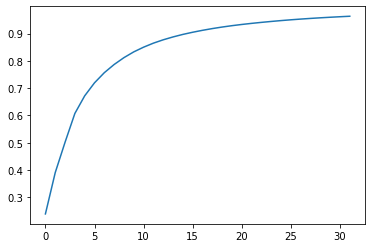

In [12]:
topk = 32
top_path_scores = explain_utils.viterbi(get_attention_tensors(attentions), topk=topk)
cum_imp = []
for i, (node, path_scores) in enumerate(top_path_scores.items()):
    #if i > 100:
    #    break
    #print(sum(top_scores[node]))
    cum = []
    for path, score in path_scores.items():
        if cum:
            cum.append(cum[-1] + score)
        else:
            cum.append(score)
    cum += [1] * (topk - len(cum))
    cum_imp.append(cum)
    #    print(path, score)
    #print()
cum_imp = np.array(cum_imp)
plt.plot(cum_imp.mean(0))

### Top paths (remove duplicated) cumlative importance

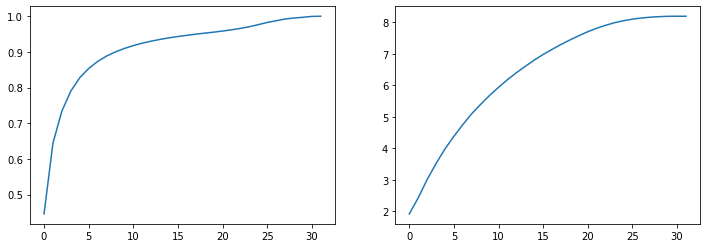

In [13]:
cum_imp = []
cum_node_cnt = []
for i, (node, path_scores) in enumerate(top_path_scores.items()):
    cum = []
    cum2 = []
    cum_nodes = set()
    norm_scores = {}
    for path, score in path_scores.items():
        path = tuple(list(sorted(set(path))))
        norm_scores[path] = norm_scores.get(path, 0) + score
    norm_scores = list(sorted(list(norm_scores.items()), key=lambda _: _[1], reverse=True))
    for path, score in norm_scores:
        if cum:
            cum.append(cum[-1] + score)
        else:
            cum.append(score)
        cum_nodes |= set(path)
        cum2.append(len(cum_nodes))
    cum += [1] * (32 - len(cum))
    cum2 += [cum2[-1]] * (32 - len(cum2))
    cum_imp.append(cum)
    cum_node_cnt.append(cum2)
    #    print(path, score)
    #print()
cum_imp = np.array(cum_imp)
cum_node_cnt = np.array(cum_node_cnt)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(cum_imp.mean(0))
plt.subplot(1,2,2)
plt.plot(cum_node_cnt.mean(0))

### Explainer

In [14]:
ex = explainer.LinkPredictionExplainer()
ex.fit(get_attention_tensors(attentions), topk=16)

100%|██████████| 3327/3327 [00:00<00:00, 5673.64it/s]


{(158, 1): 0.3578535420820117, (158, 1097): 0.061747439205646515, (158, 2919): 0.23063638992607594, (1, 486): 0.05133945122361183, (1, 1097): 0.04901326447725296, (1, 2919): 0.0753551535308361, (2919, 1587): 0.03472067043185234, (2919, 1575): 0.02755587175488472, (2919, 2404): 0.027398429811000824, (2919, 2478): 0.026657354086637497, (2919, 1358): 0.026613755151629448, (1097, 2933): 0.054872337728738785, (1097, 1467): 0.05670958757400513, (1097, 221): 0.05626809410750866, (1097, 2648): 0.054612262174487114, (2648, 1894): 0.014406955800950527, (1097, 559): 0.040115656331181526, (1097, 158): 0.04018017370253801, (2648, 1901): 0.013379917480051517, (559, 1570): 0.013164320029318333}


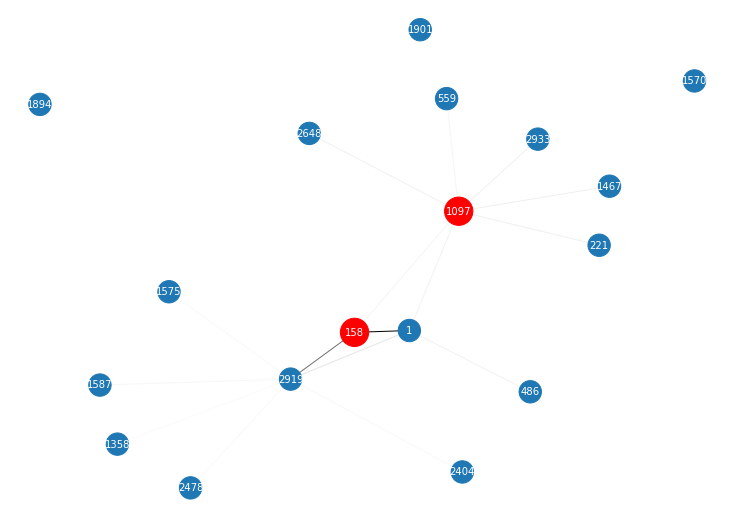

({158: OrderedDict([((158, 158, 158), 0.066224016),
               ((1, 158, 158), 0.06535978),
               ((1097, 158, 158), 0.06174744),
               ((2919, 158, 158), 0.060919702),
               ((1, 1, 158), 0.051848672),
               ((158, 1, 158), 0.05135345),
               ((486, 1, 158), 0.05133945),
               ((1097, 1, 158), 0.049013264),
               ((2919, 1, 158), 0.048355147),
               ((1587, 2919, 158), 0.03472067),
               ((1575, 2919, 158), 0.027555872),
               ((2404, 2919, 158), 0.02739843),
               ((1, 2919, 158), 0.027000006),
               ((158, 2919, 158), 0.026770607),
               ((2478, 2919, 158), 0.026657354),
               ((1358, 2919, 158), 0.026613755)]),
  1097: OrderedDict([((2933, 2933, 1097), 0.0300723),
               ((1467, 1467, 1097), 0.028840136),
               ((221, 221, 1097), 0.028616477),
               ((1097, 1467, 1097), 0.027869452),
               ((1097, 221, 1097), 0.02765161

In [15]:
ex.explain([158, 1097])